In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
print('executd')

executd


In [6]:
# =========================
# 1. Load dataset
# =========================
print("Loading dataset...")
df = pd.read_csv(
    "Real_Estate_Sales_2001_to_2023.csv",
    low_memory=False
)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# =========================
# 2. Date parsing
# =========================
print("\nParsing dates...")
df["Date Recorded"] = pd.to_datetime(df["Date Recorded"], errors="coerce")
print("\ndone...")

Loading dataset...
Dataset loaded: 1141722 rows, 14 columns

Parsing dates...

done...


In [7]:
# =========================
# 3. Data_clean
# =========================
print("Dropping missing values...")
initial_rows = df.shape[0]
df = df.dropna(subset=["Town","Residential Type","Assessed Value","Sales Ratio","Sale Amount","List Year","Date Recorded"])
print(f"Dropped {initial_rows - df.shape[0]} rows with missing values")

Dropping missing values...
Dropped 403130 rows with missing values


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 738592 entries, 0 to 1141721
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Serial Number     738592 non-null  int64         
 1   List Year         738592 non-null  int64         
 2   Date Recorded     738592 non-null  datetime64[ns]
 3   Town              738592 non-null  object        
 4   Address           738588 non-null  object        
 5   Assessed Value    738592 non-null  float64       
 6   Sale Amount       738592 non-null  float64       
 7   Sales Ratio       738592 non-null  object        
 8   Property Type     738592 non-null  object        
 9   Residential Type  738592 non-null  object        
 10  Non Use Code      210390 non-null  object        
 11  Assessor Remarks  150259 non-null  object        
 12  OPM remarks       12949 non-null   object        
 13  Location          253131 non-null  object        
dtypes: datet

In [10]:
# =========================
# 4. Feature engineering
# =========================
print("\nEngineering features...")
df["Years_Since_List"] = df["Date Recorded"].dt.year - df["List Year"]

# Remove invalid rows created by bad dates
df = df[df["Years_Since_List"] >= 0]
print(f"Final dataset: {df.shape[0]} rows")

# =========================
# 5. Feature / target split
# =========================
features = [
    "Town",
    "Residential Type",
    "Assessed Value",
    "Sales Ratio",
    "Years_Since_List"
]

X = df[features].copy()
y = df["Sale Amount"]

# =========================
# 6. Encode categorical features
# =========================
print("\nEncoding categorical features...")
cat_cols = ["Town", "Residential Type"]
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X[cat_cols] = encoder.fit_transform(X[cat_cols])
print('done')


Engineering features...
Final dataset: 738541 rows

Encoding categorical features...
done


In [11]:
# =========================
# 7. Train-test split
# =========================
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Splitting data into train and test sets...
Training set: 590832 samples
Test set: 147709 samples


In [14]:
# =========================
# 8. Train XGBoost model with GPU
# =========================
print("\n" + "="*50)
print("Training XGBoost model...")
print("="*50)

# XGBoost parameters for GPU
params = {
    'tree_method': 'hist',        
    #'device': 'cuda',# Use GPU
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

xgb_model = xgb.XGBRegressor(**params)

# Convert 'Sales Ratio' to numeric, coercing errors
# This ensures XGBoost receives numeric data for this column
X_train['Sales Ratio'] = pd.to_numeric(X_train['Sales Ratio'], errors='coerce')
X_test['Sales Ratio'] = pd.to_numeric(X_test['Sales Ratio'], errors='coerce')

# Fit the model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("\nModel training completed!")


Training XGBoost model...
[0]	validation_0-rmse:741119.36717
[1]	validation_0-rmse:716004.86308
[2]	validation_0-rmse:692996.07052
[3]	validation_0-rmse:676484.19212
[4]	validation_0-rmse:660964.80920
[5]	validation_0-rmse:647817.77378
[6]	validation_0-rmse:636598.51793
[7]	validation_0-rmse:626295.73036
[8]	validation_0-rmse:618131.17362
[9]	validation_0-rmse:608457.40677
[10]	validation_0-rmse:604674.00518
[11]	validation_0-rmse:599793.10779
[12]	validation_0-rmse:593839.46851
[13]	validation_0-rmse:590557.97431
[14]	validation_0-rmse:583114.80666
[15]	validation_0-rmse:579166.15749
[16]	validation_0-rmse:576522.36618
[17]	validation_0-rmse:573214.77274
[18]	validation_0-rmse:570290.76256
[19]	validation_0-rmse:568085.23030
[20]	validation_0-rmse:566405.34753
[21]	validation_0-rmse:566556.36405
[22]	validation_0-rmse:563089.39094
[23]	validation_0-rmse:556049.79510
[24]	validation_0-rmse:554799.46097
[25]	validation_0-rmse:553380.77618
[26]	validation_0-rmse:552447.87191
[27]	valida

In [15]:
# =========================
# 9. Evaluation
# =========================
print("\n" + "="*50)
print("Evaluating model...")

y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"R²   : {r2:.4f}")
print(f"MAE  : ${mae:,.2f}")
print(f"RMSE : ${rmse:,.2f}")



Evaluating model...

Model Performance:
R²   : 0.6157
MAE  : $35,357.04
RMSE : $476,968.96


In [16]:
# =========================
# 10. Feature importance
# =========================
print("\n" + "="*50)
print("Feature Importance:")

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df.to_string(index=False))

# =========================
# 11. Save model artifact
# =========================
print("\nSaving model...")
artifact = {
    "model": xgb_model,
    "encoder": encoder,
    "features": features,
    "metrics": {
        "r2": r2,
        "mae": mae,
        "rmse": rmse
    }
}

with open("real_estate_xgb_model_cpu.pkl", "wb") as f:
    pickle.dump(artifact, f)

print("✓ Model saved as 'real_estate_xgb_model.pkl'")



Feature Importance:
         Feature  Importance
            Town    0.375591
  Assessed Value    0.333267
     Sales Ratio    0.167289
Residential Type    0.120871
Years_Since_List    0.002982

Saving model...
✓ Model saved as 'real_estate_xgb_model.pkl'


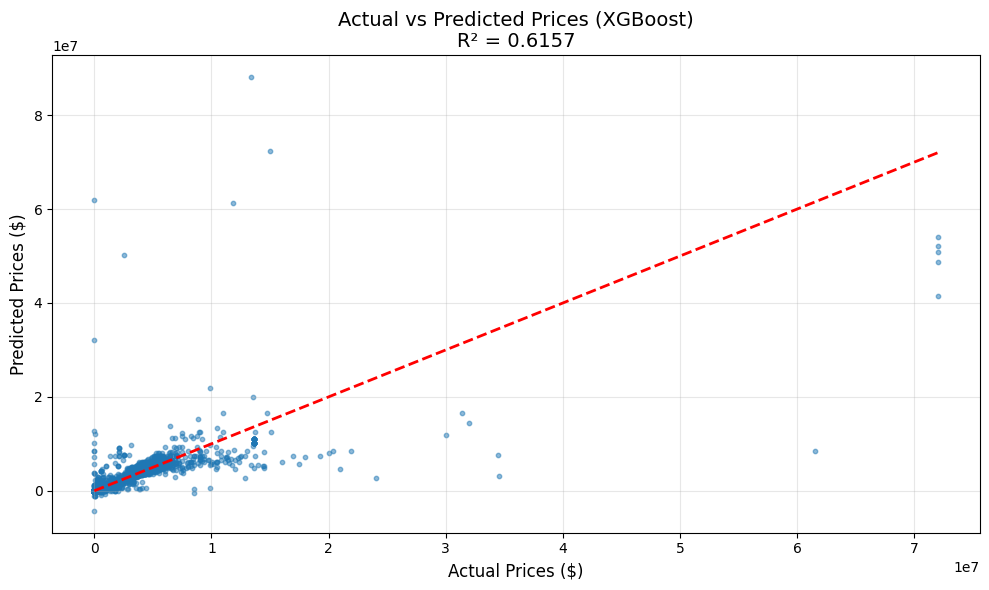

In [17]:
# =========================
# 12. Visualization
# =========================
# Plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices ($)", fontsize=12)
plt.ylabel("Predicted Prices ($)", fontsize=12)
plt.title(f"Actual vs Predicted Prices (XGBoost)\nR² = {r2:.4f}", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()